# sklearn.linear_model.SGDClassifier

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xml.etree.ElementTree as ET
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP_WORDS
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOP_WORDS
from spacy.lang.it.stop_words import STOP_WORDS as IT_STOP_WORDS
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
! python3.11 -m spacy download en_core_web_sm
! python3.11 -m spacy download fr_core_news_sm
! python3.11 -m spacy download it_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 13.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 19.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


# XML Reading function dico TRAIN (instead il faut importer dico pickle)

In [6]:

def parse_xml_to_dict(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    data_dict = {}
    for doc in root.findall('doc'):
        text_parts = []
        for p in doc.find('texte').findall('p'):
            if p.text:
                text_parts.append(p.text)
        
        text = ' '.join(text_parts)
        label = doc.find('.//PARTI').attrib['valeur']
        doc_id = doc.attrib['id']
        data_dict[doc_id] = (text, label)
    
    return data_dict

In [22]:

def lemmatize_and_remove_stopwords(text, language):
    if language == 'english':
        nlp = spacy.load('en_core_web_sm')
        stop_words = EN_STOP_WORDS
    elif language == 'french':
        nlp = spacy.load('fr_core_news_sm')
        stop_words = FR_STOP_WORDS
    elif language == 'italian':
        nlp = spacy.load('it_core_news_sm')
        stop_words = IT_STOP_WORDS
    else:
        raise ValueError("Y a pas de langue comme ça :(")

    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

def nettoyer_dicos(dico, langue):
    cleaned_dict = {}
    for doc_id, (text, label) in dico.items():
        cleaned_text = lemmatize_and_remove_stopwords(text, langue)
        cleaned_dict[doc_id] = (cleaned_text, label)
    return cleaned_dict

In [7]:
train_en = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_en.xml")
train_fr = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_fr.xml")
train_it = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_it.xml")


In [30]:
# Pour sauvegarder la version dirty de train corpus
data_list = [(text_label[0], text_label[1]) for text_label in train_en.values()]
data_np = np.array(data_list)
dirty_train_dict_en = {'data_train_en': data_np}
data_list = [(text_label[0], text_label[1]) for text_label in train_fr.values()]
data_np = np.array(data_list)
dirty_train_dict_fr = {'data_train_fr': data_np}
data_list = [(text_label[0], text_label[1]) for text_label in train_it.values()]
data_np = np.array(data_list)
dirty_train_dict_it = {'data_train_it': data_np}

dirty_train_data = {**dirty_train_dict_en, **dirty_train_dict_fr, **dirty_train_dict_it}

In [ ]:
#later is imported into pickle

train_en = nettoyer_dicos(train_en, 'english')
train_fr = nettoyer_dicos(train_fr, 'french')
train_it = nettoyer_dicos(train_it, 'italian')

# Crééation d'un dico TEST ((instead il faut importer dico pickle))

In [9]:
def parse_xml_and_labels(xml_file, labels_file):
    test_labels_dict = {}
    with open(labels_file, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                doc_id = parts[0]
                label = parts[1]
                test_labels_dict[doc_id] = label
            #else:
                #print('There is no class label for : ', line, str(labels_file.split('.')[-2]))
    
    def parse_xml_to_dict(file_path):
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data_dict = {}
        for doc in root.findall('doc'):
            text_parts = []
            for p in doc.find('texte').findall('p'):
                if p.text:
                    text_parts.append(p.text)
            
            text = ' '.join(text_parts)
            doc_id = doc.attrib['id']
            
            data_dict[doc_id] = text
        
        return data_dict
    
    test_dict = parse_xml_to_dict(xml_file)
    final_test_data = {}
    for doc_id, text in test_dict.items():
        if doc_id in test_labels_dict:
            label = test_labels_dict[doc_id]
            final_test_data[doc_id] = (text, label)
    
    return final_test_data


In [29]:
test_en = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_en.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_en.txt")
len(test_en)

test_fr = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_fr.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_fr.txt")
len(test_fr)

test_it = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_it.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_it.txt")
len(test_it)

# Creation de dico combiné

data_list = [(text_label[0], text_label[1]) for text_label in test_en.values()]
dirty_test_dict_en = {'data_test_en': np.array(data_list)}

data_list = [(text_label[0], text_label[1]) for text_label in test_fr.values()]
dirty_test_dict_fr = {'data_test_fr': np.array(data_list)}

data_list = [(text_label[0], text_label[1]) for text_label in test_it.values()]
dirty_test_dict_it = {'data_test_it': np.array(data_list)}
dirty_test_data = {**dirty_test_dict_en, **dirty_test_dict_fr, **dirty_test_dict_it}

12915

In [48]:
from tqdm import tqdm 

def lemmatize_and_remove_stopwords(text, language):
    if language == 'en':
        nlp = spacy.load('en_core_web_sm')
        stop_words = EN_STOP_WORDS
    elif language == 'fr':
        nlp = spacy.load('fr_core_news_sm')
        stop_words = FR_STOP_WORDS
    elif language == 'it':
        nlp = spacy.load('it_core_news_sm')
        stop_words = IT_STOP_WORDS
    else:
        raise ValueError("Pas de langue comme ça :(")

    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

def nettoyer_dictionnaire(dictionnaire):
    total_docs = sum(len(array_data) for array_data in dictionnaire.values())
    processed_docs = 0
    cleaned_dict = {}
    for key, array_data in dictionnaire.items():
        lang = key.split('_')[-1]
        with tqdm(total=len(array_data), desc=f'Processing {key}', position=0, leave=True) as pbar:
            cleaned_array = []
            for text, label in array_data:
                cleaned_text = lemmatize_and_remove_stopwords(text.item(), lang)
                cleaned_array.append([cleaned_text, label])
                processed_docs += 1
                progress_percent = processed_docs / total_docs * 100
                pbar.set_postfix({'Processed': f'{progress_percent:.2f}%'})
                pbar.update(1)
            cleaned_dict[key] = np.array(cleaned_array, dtype=object)

    return cleaned_dict

Processing data_test_it: 100%|██████████| 12915/12915 [1:24:08<00:00,  2.56it/s, Processed=100.00%]


In [28]:
# save dictionary to person_data.pkl file
with open('/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/dirty_test_dictionary.pkl', 'wb') as fp:
    pickle.dump(dirty_test_data, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# Importer fichiers pickle

In [2]:

# Read dictionary pkl file
with open('/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/clean_train_dictionary.pkl', 'rb') as fp:
    clean_train_dictionary = pickle.load(fp)

with open('/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/clean_test_dictionary.pkl', 'rb') as fp:
    clean_test_dictionary = pickle.load(fp)

with open('/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/dirty_train_dictionary.pkl', 'rb') as fp:
    dirty_train_dictionary = pickle.load(fp)

with open('/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/dirty_test_dictionary.pkl', 'rb') as fp:
    dirty_test_dictionary = pickle.load(fp)

# Visualisation 


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


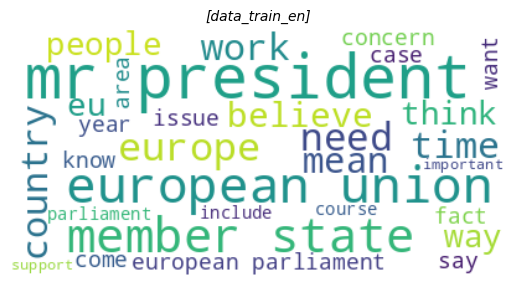

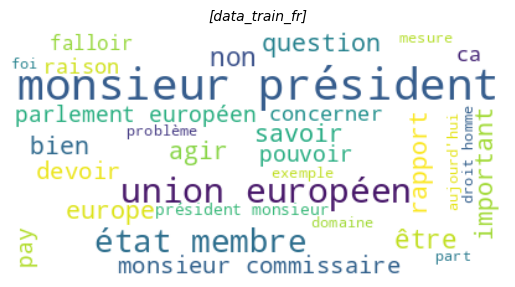

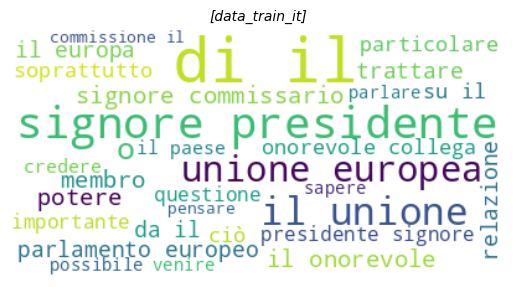

In [16]:
import matplotlib.pyplot as plt
! pip install wordcloud
from wordcloud import WordCloud


def generate_wordcloud(text_array):

    texts = text_array[:, 0]  


    all_text = ' '.join(texts)


    wordcloud = WordCloud(max_font_size=50, max_words=30, background_color='white').generate(all_text)


    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


for key, value in clean_train_dictionary.items():
    plt.title(f'[{key}]', color='black', fontsize=10, style='oblique')
    generate_wordcloud(value)


# ALGO SGD DIRTY

In [5]:
#######################################################
combined_train_data = [data for key, data in dirty_train_dictionary.items()]
combined_test_data = [data for key, data in dirty_test_dictionary.items()]

# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)

#######################################################
    

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(n_jobs=-1)),
])


text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")


Accuracy: 0.751219512195122
Precision: 0.7527133318548537
Recall: 0.751219512195122
F1 Score: 0.7503421036981882


In [6]:

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(n_jobs=-1)),
])


text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.6187637114466382
Precision: 0.6453933908998774
Recall: 0.6187637114466382
F1 Score: 0.6046172846645307


# Algo SGDClassifier cleaned

In [8]:
#######################################################
combined_train_data = [data for key, data in clean_train_dictionary.items()]
combined_test_data = [data for key, data in clean_test_dictionary.items()]

# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)

#######################################################
    

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(n_jobs=-1)),
])


text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.7308555942702284
Precision: 0.730730371429685
Recall: 0.7308555942702284
F1 Score: 0.7299091316244071


In [9]:

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(n_jobs=-1)),
])

text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.6014195380049039
Precision: 0.6291363318376219
Recall: 0.6014195380049039
F1 Score: 0.5835178092273435


________________________________________________________________________________________________________________________________________________________________________________

# Tout ce qui vient ici c'est du n'importe quoi

In [5]:
# pour trouver les hyper-paramètres

combined_train_data = [clean_train_dictionary['data_train_en'], clean_train_dictionary['data_train_fr'], clean_train_dictionary['data_train_it']]
combined_test_data = [clean_test_dictionary['data_test_en'], clean_test_dictionary['data_test_fr'], clean_test_dictionary['data_test_it']]

# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)
#######################################################
    
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier())
])

param_dist = {
    'vect__max_features': randint(500, 10000),  # Random integer values between 500 and 10000
    'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'clf__penalty': ['l1', 'l2'],
    'clf__max_iter': randint(1000, 3000),
    'clf__loss': ['hinge', 'log', 'modified_huber'],
    'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'clf__epsilon': [0.1, 0.01, 0.001],
    'clf__shuffle': [True, False],
    'clf__early_stopping': [True, False],
    'clf__eta0': [0.01, 0.1, 0.5]  # Set appropriate values for eta0
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(text_clf, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)
random_search.fit(train_texts, train_labels)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Get predictions using the best model
best_model = random_search.best_estimator_
predicted_labels = best_model.predict(test_texts)

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
400 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
255 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, *

Best Parameters: {'clf__alpha': 0.001, 'clf__early_stopping': False, 'clf__epsilon': 0.1, 'clf__learning_rate': 'optimal', 'clf__loss': 'hinge', 'clf__max_iter': 2014, 'clf__penalty': 'l2', 'clf__shuffle': True, 'vect__max_features': 8588}
Accuracy: 0.5288940508452703
Precision: 0.541754412644288
Recall: 0.5288940508452703
F1 Score: 0.4981908262176517


In [12]:

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(alpha=0.001, early_stopping=False, epsilon=0.1, max_iter=2000, loss="hinge", n_jobs=-1, learning_rate="optimal", penalty='l2',shuffle=True)),
])


text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.5919731578268164
Precision: 0.6208349077494447
Recall: 0.5919731578268164
F1 Score: 0.572472551050731


In [20]:

combined_train_data = [data for key, data in cleaned_train_data.items()]
combined_test_data = [data for key, data in cleaned_test_data.items()]



# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)
#######################################################


text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(n_jobs=-1)),
])


text_clf.fit(train_texts, train_labels)

predicted_labels = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

precision = precision_score(test_labels, predicted_labels, average='weighted')
print(f"Precision: {precision}")
recall = recall_score(test_labels, predicted_labels, average='weighted')
print(f"Recall: {recall}")
f1 = f1_score(test_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.7373080397470642
Precision: 0.7370122857611955
Recall: 0.7373080397470642
F1 Score: 0.7364168015306236


# Étude pour voir les traits les plus discriminants 

In [19]:

tfidf_vectorizer = text_clf.named_steps['vect']

feature_names = tfidf_vectorizer.get_feature_names_out()
feature_weights = tfidf_vectorizer.idf_


features_and_weights = list(zip(feature_names, feature_weights))
sorted_features = sorted(features_and_weights, key=lambda x: x[1], reverse=True)


top_n = 50
top_features = sorted_features[:top_n]
for feature, weight in top_features:
    print(f"Feature: {feature}, Weight: {weight}")

Feature: 000msv, Weight: 11.276963073103179
Feature: 001, Weight: 11.276963073103179
Feature: 0022, Weight: 11.276963073103179
Feature: 00h15, Weight: 11.276963073103179
Feature: 010, Weight: 11.276963073103179
Feature: 0278, Weight: 11.276963073103179
Feature: 0318, Weight: 11.276963073103179
Feature: 0542, Weight: 11.276963073103179
Feature: 0548, Weight: 11.276963073103179
Feature: 0648, Weight: 11.276963073103179
Feature: 0661, Weight: 11.276963073103179
Feature: 070, Weight: 11.276963073103179
Feature: 077, Weight: 11.276963073103179
Feature: 0880, Weight: 11.276963073103179
Feature: 0ostituzione, Weight: 11.276963073103179
Feature: 0right, Weight: 11.276963073103179
Feature: 0sposizione, Weight: 11.276963073103179
Feature: 100000, Weight: 11.276963073103179
Feature: 10426, Weight: 11.276963073103179
Feature: 10493ce, Weight: 11.276963073103179
Feature: 104a, Weight: 11.276963073103179
Feature: 1051, Weight: 11.276963073103179
Feature: 10a, Weight: 11.276963073103179
Feature: 10bi

# Playing with the model

In [7]:
# Getting all classes of the model
unique_labels = text_clf.named_steps['clf'].classes_
print(f"All unique labels: {unique_labels}")

All unique labels: ['ELDR' 'GUE-NGL' 'PPE-DE' 'PSE' 'Verts-ALE']


In [84]:
new_text = "L'élection ne sera pas efficace ni écologique, verte et responsable si les participants ne sont pas informés, si le processus n'est pas transparent et si les normes éthiques ne sont pas respectées."
predicted_label = text_clf.predict([new_text])

print(f"Predicted label for the text: {predicted_label[0]}")

Predicted label for the text: GUE-NGL


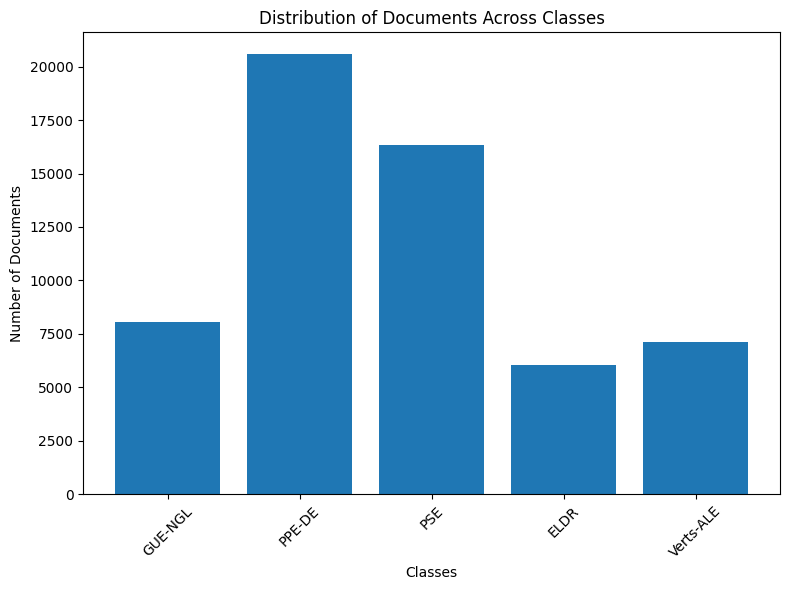

In [9]:
# Distribution of Documents Across Classes

class_counts = {}
for doc_tuple in combined_train_data.values():
    label = doc_tuple[1]  
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Classes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


# Kernal approximation

In [87]:

combined_train_data = [clean_train_dictionary['data_train_en'], clean_train_dictionary['data_train_fr'], clean_train_dictionary['data_train_it']]
combined_test_data = [clean_test_dictionary['data_test_en'], clean_test_dictionary['data_test_fr'], clean_test_dictionary['data_test_it']]

# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)
# Your remaining code for the pipeline and evaluation
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('rbf_sampler', RBFSampler(gamma=1, random_state=1)),  # Applying RBFSampler for kernel approximation
    ('clf', SGDClassifier(max_iter=1000)),
])

text_clf.fit(train_texts, train_labels)
test_predictions = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.3123241708607562
